In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
import os
import sys

from PIL import Image
import numpy as np
from scipy import ndimage

in_path = 'gdrive/My Drive/CV_semantic/training'
detection_thres = 0.05

for in_file in os.listdir(in_path):
    if not in_file.endswith("_detect.png"):
        continue
    in_fn = os.path.join(in_path, in_file)
    out_fn = in_fn[:-len('_detect.png')] + '_detbinary.png'
    if not os.path.isfile(in_fn):
        continue

    im = np.array(Image.open(in_fn).convert('L')).astype(np.float32) / 255.0

    # Detecting blobs in the detection image
    dot = ndimage.filters.gaussian_filter(im, 2.0, mode='mirror')

    # Merge detection and segmentation results
    seg_region = (dot > detection_thres)

    labeled_region, n_region = ndimage.measurements.label(seg_region)

    labeled_im = np.zeros_like(seg_region, dtype=np.uint8)
    for regi in range(1, n_region+1):
        bin_region = (labeled_region == regi)
        x_coors = np.where(bin_region.sum(axis=1))
        y_coors = np.where(bin_region.sum(axis=0))
        minx = np.min(x_coors)
        maxx = np.max(x_coors)
        miny = np.min(y_coors)
        maxy = np.max(y_coors)
        labeled_im[(minx+maxx)//2, (miny+maxy)//2] = 255
    print (in_file, n_region)

    Image.fromarray(labeled_im).save(out_fn)

lgg_image02_detect.png 30
hnsc_image08_detect.png 152
hnsc_image05_detect.png 98
lung_image04_detect.png 146
gbm_image01_detect.png 80
gbm_image04_detect.png 216
lgg_image07_detect.png 52
lung_image01_detect.png 59
lung_image06_detect.png 91
gbm_image03_detect.png 163
hnsc_image07_detect.png 177
lung_image03_detect.png 64
lgg_image08_detect.png 114
hnsc_image02_detect.png 65
gbm_image06_detect.png 232
lgg_image05_detect.png 142
gbm_image05_detect.png 141
hnsc_image01_detect.png 36
gbm_image08_detect.png 123
lgg_image06_detect.png 93
lgg_image03_detect.png 149
lung_image05_detect.png 93
hnsc_image04_detect.png 121
lung_image08_detect.png 79
gbm_image07_detect.png 124
lung_image02_detect.png 131
hnsc_image03_detect.png 181
lung_image07_detect.png 46
lgg_image04_detect.png 72
lgg_image01_detect.png 62
hnsc_image06_detect.png 164
gbm_image02_detect.png 169


In [0]:
from tqdm import tqdm
import torch as t

In [4]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x57a7c000 @  0x7fdac5d2c2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [8]:
%%writefile read_file.py

import numpy as np
from scipy import ndimage
from PIL import Image

def read_instance(im_file, resize_factor):
    file_id = im_file[: -len('.png')]
    rf = resize_factor

    f = open('{}_mask.txt'.format(file_id), 'r')
    lines = [line.strip() for line in f.readlines()]
    f.close()

    for n, line in enumerate(lines):
        if n == 0:
            patch_H = int(line.split()[0])
            patch_W = int(line.split()[1])
            seg_ground_truth = np.zeros((patch_H * patch_W, )).astype(np.uint32)
            continue
        seg_ground_truth[n-1] = int(line)
    seg_ground_truth = np.array(Image.fromarray(
        seg_ground_truth.reshape(patch_H, patch_W)).resize(
        (patch_H*rf, patch_W*rf), resample=Image.NEAREST))

    he_image = np.array(Image.open('{}.png'.format(file_id)).convert('RGB').resize(
        (patch_H*rf, patch_W*rf), resample=Image.BILINEAR))
    detection_blur = np.array(Image.open('{}_detbinary.png'.format(file_id)).convert('L').resize(
        (patch_H*rf, patch_W*rf), resample=Image.BILINEAR))
    segmentation = np.array(Image.open('{}_segment.png'.format(file_id)).convert('L').resize(
        (patch_H*rf, patch_W*rf), resample=Image.BILINEAR))

    seg_region = (detection_blur > 50)
    labeled_region, n_region = ndimage.measurements.label(seg_region)
    detection = np.zeros_like(detection_blur, dtype=np.uint8)
    for regi in range(1, n_region+1):
        bin_region = (labeled_region == regi)
        minx = np.min(np.where(bin_region.sum(axis=1)))
        maxx = np.max(np.where(bin_region.sum(axis=1)))
        miny = np.min(np.where(bin_region.sum(axis=0)))
        maxy = np.max(np.where(bin_region.sum(axis=0)))
        detection[(minx+maxx)//2, (miny+maxy)//2] = 255

    return file_id, (patch_H, patch_W), he_image, detection, segmentation, seg_ground_truth

def read_folder(in_path):
    file_id_list = []
    original_size_list = []
    he_image_list = []
    detection_list = []
    segmentation_list = []
    seg_ground_truth_list = []

    f = open('{}/image_resize_list.txt'.format(in_path), 'r')
    lines = [line.strip() for line in f.readlines()]
    f.close()
    for n, line in enumerate(lines):
        im_name = '{}/{}'.format(in_path, line.split()[0])
        resize_factor = int(line.split()[1])
        file_id, original_size, he_image, detection, segmentation, seg_ground_truth = read_instance(im_name, resize_factor)

        file_id_list.append(file_id)
        original_size_list.append(original_size)
        he_image_list.append(he_image)
        detection_list.append(detection)
        segmentation_list.append(segmentation)
        seg_ground_truth_list.append(seg_ground_truth)

    return file_id_list, original_size_list, he_image_list, detection_list, segmentation_list, seg_ground_truth_list



Writing read_file.py


In [0]:
import read_file
import numpy as np
import cv2
import sys
from PIL import Image
from scipy import ndimage
from skimage.color import label2rgb

padding_size = 120
win_size = 100
min_size = 80
seg_threshold = 60
input_folder = 'gdrive/My Drive/CV_semantic/training'

def zero_padding(array, margin):
    size1, size2 = array.shape
    padded = np.zeros((size1+margin*2, size2+margin*2), dtype=array.dtype)
    padded[margin:-margin, margin:-margin] = array
    return padded

def remove_padding(array, margin):
    return array[margin:-margin, margin:-margin]

def only_keep_center_object(bin_win):
    win_size = (bin_win.shape[0]-1) // 2
    labeled_objects, n_object = ndimage.measurements.label(bin_win)
    min_dis_to_center = win_size * 2
    center_object_id = 0
    for object_id in range(1, n_object+1):
        bin_region = (labeled_objects == object_id)
        minx = np.min(np.where(bin_region.sum(axis=1)))
        maxx = np.max(np.where(bin_region.sum(axis=1)))
        miny = np.min(np.where(bin_region.sum(axis=0)))
        maxy = np.max(np.where(bin_region.sum(axis=0)))
        dis_to_center = (((minx+maxx)/2.0 - win_size)**2 + ((miny+maxy)/2.0 - win_size)**2)**0.5
        if dis_to_center < min_dis_to_center:
            min_dis_to_center = dis_to_center
            center_object_id = object_id
    return labeled_objects == center_object_id

def thresholding(gray):
    thresholded = (gray > seg_threshold)
    return thresholded

file_id_list, original_size_list, he_image_list, detection_list, segmentation_list, seg_ground_truth_list = \
    read_file.read_folder(input_folder)

#for file_id, original_size, he_image, detection, segmentation, seg_ground_truth in zip(
#        file_id_list, original_size_list, he_image_list, detection_list, segmentation_list, seg_ground_truth_list):
#    print file_id, original_size, he_image.shape, detection.shape, segmentation.shape, seg_ground_truth.shape



In [8]:
''''
import numpy
datas = []
for file_id, original_size, he_image, seg_ground_truth in zip(
        file_id_list, original_size_list, he_image_list, seg_ground_truth_list):
    x = file_id
    i = 0

    print("before")

    if(he_image.shape[0] == 500):
        #print("In loop")
        seg_ground_truth = Image.fromarray(seg_ground_truth).resize((600,600), resample=Image.NEAREST)
        seg_ground_truth = numpy.array(seg_ground_truth)
        he_image = Image.fromarray(he_image).resize((600,600), resample=Image.NEAREST)
        he_image = numpy.array(he_image)

    patch_size = 128
    for r in range(0,he_image.shape[0] - patch_size, patch_size):
        for c in range(0,he_image.shape[0] - patch_size, patch_size):
            fol_name = x.split("/",1)[1]+"_"+str(r)+str(c)
            item = {}
            
            
            #path_image = path+fol_name+'/images/'
            #path_mask = path+fol_name+'/mask/'
            image_block = he_image[r:r+patch_size,c:c+patch_size,:]
            grey_block = seg_ground_truth[r:r+patch_size,c:c+patch_size]
            item['name'] = fol_name
            item['img']= t.from_numpy(image_block)
            item['mask'] = t.from_numpy(grey_block)
            #print  image_block.shape, grey_block.shape
            datas.append(item)
            
train_data = datas
''''

SyntaxError: ignored

600


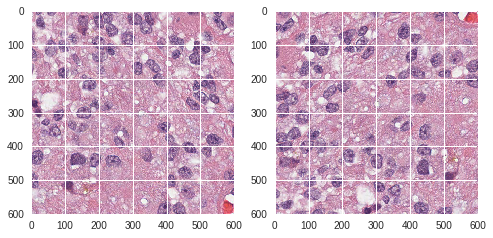

In [10]:
from skimage.color import hed2rgb, rgb2hed
import matplotlib.pyplot as plt
import numpy
datas = []

for file_id, original_size, he_image, seg_ground_truth in zip(
        file_id_list, original_size_list, he_image_list, seg_ground_truth_list):
  (rows,cols,channel) = he_image.shape
  M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
  dst = cv2.warpAffine(he_image,M,(cols,rows))
  plt.subplot(121)
  plt.imshow(he_image)
  #plt.subplot(152)
  #plt.imshow(dst)
  seg_ground_truth = seg_ground_truth.astype(np.uint8)
  (rows1, column1) = seg_ground_truth.shape
  print(rows1)
  M1 = cv2.getRotationMatrix2D((column1/2,rows1/2),90,1)
  dst1 = cv2.warpAffine(seg_ground_truth,M,(column1,rows1))
  #plt.subplot(153)
  #plt.imshow(seg_ground_truth*255)
  #plt.subplot(154)
  #plt.imshow(dst1*255)
  change_image = he_image
  adj_add = np.array([[[0.9, 0.009, 0.0007]]], dtype=np.float32);
  img = hed2rgb(rgb2hed(change_image / 255.0) + np.clip(np.random.normal(0, 0.3, (1, 1, 3)), -1, 1) * adj_add) * 255.0

  adj_range = 0.03;
  adj_add = 6;
  rgb_mean = np.mean(change_image, axis=(0, 1), keepdims=True).astype(np.float32);
  adj_magn = np.random.uniform(1 - adj_range, 1 + adj_range, (1, 1, 3)).astype(np.float32);
  change_image = (change_image - rgb_mean) * adj_magn + rgb_mean + np.random.uniform(-1.0, 1.0, (1, 1, 3)) * adj_add

  change_image = np.clip(change_image, 0, 255).astype(np.uint8)
  change_image_mask = seg_ground_truth
  plt.subplot(122)
  plt.imshow(dst)
  rotated_image = dst
  rotated_image_mask = dst1
  break

In [11]:
#!mkdir gdrive/My Drive/output_UNET
from skimage.color import hed2rgb, rgb2hed
import numpy
datas = []

for file_id, original_size, he_image, seg_ground_truth in zip(
        file_id_list, original_size_list, he_image_list, seg_ground_truth_list):
  (rows,cols,channel) = he_image.shape
  M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
  dst = cv2.warpAffine(he_image,M,(cols,rows))
  #plt.subplot(151)
  #plt.imshow(he_image)
  #plt.subplot(152)
  #plt.imshow(dst)
  seg_ground_truth = seg_ground_truth.astype(np.uint8)
  (rows1, column1) = seg_ground_truth.shape
  print(rows1)
  M1 = cv2.getRotationMatrix2D((column1/2,rows1/2),90,1)
  dst1 = cv2.warpAffine(seg_ground_truth,M,(column1,rows1))
  #plt.subplot(153)
  #plt.imshow(seg_ground_truth*255)
  #plt.subplot(154)
  #plt.imshow(dst1*255)
  change_image = he_image
  adj_add = np.array([[[0.09, 0.09, 0.007]]], dtype=np.float32);
  img = hed2rgb(rgb2hed(change_image / 255.0) + np.clip(np.random.normal(0, 0.3, (1, 1, 3)), -1, 1) * adj_add) * 255.0

  adj_range = 0.03;
  adj_add = 6;
  rgb_mean = np.mean(change_image, axis=(0, 1), keepdims=True).astype(np.float32);
  adj_magn = np.random.uniform(1 - adj_range, 1 + adj_range, (1, 1, 3)).astype(np.float32);
  change_image = (change_image - rgb_mean) * adj_magn + rgb_mean + np.random.uniform(-1.0, 1.0, (1, 1, 3)) * adj_add

  change_image = np.clip(change_image, 0, 255).astype(np.uint8)
  change_image_mask = seg_ground_truth
  #plt.subplot(155)
  #plt.imshow(change_image)
  rotated_image = dst
  rotated_image_mask = dst1
  
  x = file_id
  i = 0

  print("before")
  

  if(he_image.shape[0] == 500):
        #print("In loop")
        seg_ground_truth = Image.fromarray(seg_ground_truth).resize((600,600), resample=Image.NEAREST)
        seg_ground_truth = numpy.array(seg_ground_truth)
        he_image = Image.fromarray(he_image).resize((600,600), resample=Image.NEAREST)
        he_image = numpy.array(he_image)

  patch_size = 128
  for r in range(0,he_image.shape[0] - patch_size, patch_size):
    for c in range(0,he_image.shape[0] - patch_size, patch_size):
      fol_name = x.split("/",1)[1]+"_"+str(r)+str(c)
      item = {}
      image_block = he_image[r:r+patch_size,c:c+patch_size,:]
      grey_block = seg_ground_truth[r:r+patch_size,c:c+patch_size]
      item['name'] = fol_name
      item['img']= t.from_numpy(image_block)
      item['mask'] = t.from_numpy(grey_block)
      #print  image_block.shape, grey_block.shape
      #plt.subplot(121)
      #plt.imshow(image_block)
      #plt.subplot(122)
      #plt.imshow(grey_block)
      #datas.append(item)
      #break
    #break
     
  if(rotated_image.shape[0] == 500):
        print("In loop")
        rotated_image_mask = Image.fromarray(rotated_image_mask).resize((600,600), resample=Image.NEAREST)
        rotated_image_mask = numpy.array(rotated_image_mask)
        rotated_image = Image.fromarray(rotated_image).resize((600,600), resample=Image.NEAREST)
        rotated_image = numpy.array(rotated_image)
 

  patch_size = 128
  #plt.subplot(151)
  #plt.imshow(he_image)
  #plt.subplot(152)
  #plt.imshow(rotated_image)
  #plt.subplot(153)
  #plt.imshow(rotated_image_mask)
      
  for r in range(0,rotated_image.shape[0] - patch_size, patch_size):
    for c in range(0,rotated_image.shape[0] - patch_size, patch_size):
      fol_name = x.split("/",1)[1]+"_"+str(r)+str(c)
      item = {}
      image_block = rotated_image[r:r+patch_size,c:c+patch_size,:]
      grey_block = rotated_image_mask[r:r+patch_size,c:c+patch_size]
      item['name'] = fol_name
      item['img']= t.from_numpy(image_block)
      item['mask'] = t.from_numpy(grey_block)
      #print  image_block.shape, grey_block.shape
      datas.append(item)
      #plt.subplot(154)
      #plt.imshow(image_block)
      #plt.subplot(155)
      #plt.imshow(grey_block)
      datas.append(item)
      #break
    #break
  
      
  if(change_image.shape[0] == 500):
        #print("In loop")
        change_image_mask = Image.fromarray(change_image_mask).resize((600,600), resample=Image.NEAREST)
        change_image_mask = numpy.array(change_image_mask)
        change_image = Image.fromarray(change_image).resize((600,600), resample=Image.NEAREST)
        change_image = numpy.array(change_image)

  patch_size = 128
  for r in range(0,change_image.shape[0] - patch_size, patch_size):
    for c in range(0,change_image.shape[0] - patch_size, patch_size):
      fol_name = x.split("/",1)[1]+"_"+str(r)+str(c)
      item = {}
      image_block = change_image[r:r+patch_size,c:c+patch_size,:]
      grey_block = change_image_mask[r:r+patch_size,c:c+patch_size]
      item['name'] = fol_name
      item['img']= t.from_numpy(image_block)
      item['mask'] = t.from_numpy(grey_block)
      #print  image_block.shape, grey_block.shape
      datas.append(item)

  
  
  
  #cv2.imwrite( "gdrive/My Drive/CV_semantic/OUTPUT/Gray_Image2.jpg", he_image );
  
train_data = datas
  
  

600
before
600
before
600
before
600
before
600
before
600
before
600
before
600
before
500
before
In loop
500
before
In loop
500
before
In loop
600
before
500
before
In loop
600
before
500
before
In loop
500
before
In loop
500
before
In loop
500
before
In loop
600
before
600
before
500
before
In loop
600
before
500
before
In loop
500
before
In loop
500
before
In loop
500
before
In loop
500
before
In loop
500
before
In loop
500
before
In loop
500
before
In loop
500
before
In loop
500
before
In loop


datas = []
for file_id, original_size, he_image, seg_ground_truth in zip(
        file_id_list, original_size_list, he_image_list, seg_ground_truth_list):
    item = {}
    item['name'] = file_id
    item['img']= t.from_numpy(he_image)
    item['mask'] = t.from_numpy(seg_ground_truth)
    
    print file_id, original_size, he_image.shape, seg_ground_truth.shape
    datas.append(item)
train_data = datas

In [12]:
print(len(train_data))
X = train_data[0:1400]
val_data = train_data[1401:1536]
print(len(X))
print(len(val_data))
train_data = X

1536
1400
135


In [0]:
import PIL
from torchvision import transforms as tsf
class Dataset():
    def __init__(self,data,source_transform,target_transform):
        self.datas = data
#         self.datas = train_data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),]
)

dataset = Dataset(train_data,s_trans,t_trans)
dataloader = t.utils.data.DataLoader(dataset,num_workers=2,batch_size=4)
valdata = Dataset(val_data,s_trans,t_trans)
valloader = t.utils.data.DataLoader(valdata,num_workers=2,batch_size=1)

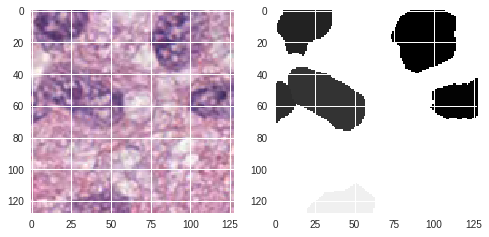

In [14]:
import matplotlib.pyplot as plt
img,mask = dataset[14]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

In [0]:
# sub-parts of the U-Net model

from torch import nn
import torch.nn.functional as F


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def _init_(self, in_ch, out_ch):
        super(double_conv, self)._init_()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def _init_(self, in_ch, out_ch):
        super(inconv, self)._init_()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def _init_(self, in_ch, out_ch):
        super(down, self)._init_()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def _init_(self, in_ch, out_ch, bilinear=True):
        super(up, self)._init_()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2)
        else:
            self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def _init_(self, in_ch, out_ch):
        super(outconv, self)._init_()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def _init_(self, n_channels, n_classes):
        super(UNet, self)._init_()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = t.nn.functional.sigmoid(x)
        return x

In [0]:
# sub-parts of the U-Net model


from torch import nn
import torch.nn.functional as F


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.PReLU(),
            nn.BatchNorm2d(out_ch),
            #nn.ReLU(inplace=True),
            
            #nn.ReflectionPad2d(padding=(2)//2),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.PReLU(),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2)
        else:
            self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        #x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        #diffY // 2, int(diffY / 2)))
        x2 = nn.functional.interpolate(x2, size=(x1.shape[2],x1.size()[3]), 
                                       scale_factor=None, mode='nearest', align_corners=None)
            
        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)
        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding = 1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=3, padding = 1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 32 * 32, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 32 * 32)
        #xs = xs.view(-1, 40960)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

        

    def forward(self, x):
        x = self.stn(x)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = t.nn.functional.sigmoid(x)
        return x
  

In [0]:
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

In [18]:
import torch
model = UNet(3,1).cuda()
optimizer = t.optim.Adam(model.parameters(),lr = 1e-3)

for epoch in range(20):
    print("epoch")
    print(epoch)
    loss_val =0
    total_val = 0
    
    for x_train, y_train  in dataloader:
        x_train = t.autograd.Variable(x_train).cuda()
        y_train = t.autograd.Variable(y_train).cuda()
        #print(x_train.shape, y_train.shape)
        optimizer.zero_grad()
        o = model(x_train)
        #print(o.shape)
        loss = soft_dice_loss(o, y_train)
        loss_val = loss
        
        loss.backward()
        optimizer.step()
    print("training Loss:")
    print(loss_val.item())
    if(epoch%2 == 0):
        i =0
        for x_train, y_train  in valloader:
            i = i+1
            x_train = t.autograd.Variable(x_train).cuda()
            y_train = t.autograd.Variable(y_train).cuda()
            o = model(x_train)
            loss = soft_dice_loss(o, y_train)
            total_val = loss.item()+total_val
        print("val_Loss:")
        print(total_val/i)
        
        

epoch
0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


training Loss:
0.640231728553772
val_Loss:
0.7678780370288425
epoch
1
training Loss:
0.6357618570327759
epoch
2
training Loss:
0.6381089687347412
val_Loss:
0.7705344067679512
epoch
3
training Loss:
0.6308399438858032
epoch
4
training Loss:
0.6312927007675171
val_Loss:
0.7457320495888039
epoch
5
training Loss:
0.6300278902053833
epoch
6
training Loss:
0.6291614174842834
val_Loss:
0.7405126805658694
epoch
7
training Loss:
0.6281305551528931
epoch
8
training Loss:
0.6353867650032043
val_Loss:
0.7395838755148428
epoch
9
training Loss:
0.6277831792831421
epoch
10
training Loss:
0.6318160891532898
val_Loss:
0.7381019901346277
epoch
11
training Loss:
0.6311883330345154
epoch
12
training Loss:
0.6289314031600952
val_Loss:
0.7412548740704854
epoch
13
training Loss:
0.6284310221672058
epoch
14
training Loss:
0.6348227262496948
val_Loss:
0.7384560955895318
epoch
15
training Loss:
0.6266584396362305
epoch
16
training Loss:
0.6303820013999939
val_Loss:
0.7308819519148932
epoch
17
training Loss:
0.6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile,

1.0 -0.827451
tensor(0.3451) tensor(0.)
(128, 128)
1.0 -0.85882354
tensor(0.2314) tensor(0.)
(128, 128)


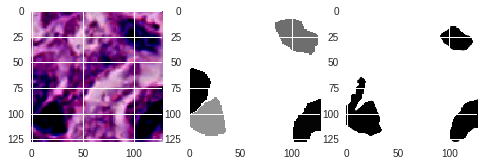

In [19]:
q = 1
for x_train, y_train  in valloader:
  x_train = t.autograd.Variable(x_train, volatile=True).cuda()
  #print(x_train.shape)
  o = model(x_train)

  tm=o[0][0].data.cpu().numpy()
  plt.subplot(131)
  print(x_train[0].data.cpu().permute(1,2,0).numpy().max(), x_train[0].data.cpu().permute(1,2,0).numpy().min())
  print(y_train[0][0].max(),y_train[0][0].min())
  X = x_train[0].data.cpu().permute(1,2,0).numpy()
  
  plt.imshow(np.clip(X,0,1))
  plt.subplot(132)
  #print(y_train[0][0].shape)
  #img,mask = valdata[0]
  #print(y_train[0][0].max)
  
  plt.imshow(y_train[0][0]*255)
  print(tm.shape)
  plt.subplot(133)
  plt.imshow(tm)
  if (q == 2):
    break
  q = q+1
  #plt.imshow(mask)
  #break
    #m = l+22
    #plt.subplot(m)
    #plt.imshow(tm)
  

test_folder = 'testing'

---



---


test_file_id_list, test_original_size_list, test_he_image_list, test_detection_list, test_segmentation_list, test_seg_ground_truth_list = \
    read_file.read_folder(test_folder)

In [0]:
test_folder = 'gdrive/My Drive/CV_semantic/testing/'
test_file_id_list, test_original_size_list, test_he_image_list, test_detection_list, test_segmentation_list, test_seg_ground_truth_list = \
    read_file.read_folder(test_folder)

gdrive/My Drive/CV_semantic/testing//lgg_image01 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image01 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image01 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image01 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image01 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image01 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image01 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image01 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image01 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image01 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image01 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image01 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image01 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//l

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)



gdrive/My Drive/CV_semantic/testing//lgg_image05 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image05 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image05 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image05 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image05 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image05 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image05 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image05 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image05 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image05 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image05 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image05 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//lgg_image05 (128, 128, 3) (128, 128)
gdrive/My Drive/CV_semantic/testing//

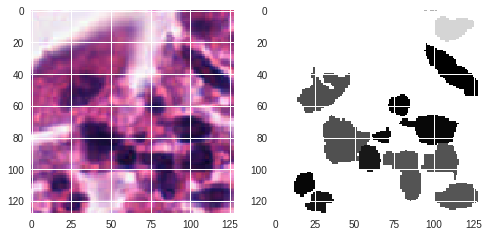

In [21]:
test_datas = []
for file_id, he_image_test,test_detect,test_segment, seg_ground_truth_test in zip(
        test_file_id_list, test_he_image_list, test_detection_list, test_segmentation_list, test_seg_ground_truth_list):
    
  x = file_id  
  if(he_image_test.shape[0] == 500):
        seg_ground_truth_test = Image.fromarray(seg_ground_truth_test).resize((600,600), resample=Image.NEAREST)
        seg_ground_truth_test = numpy.array(seg_ground_truth_test)
        he_image_test = Image.fromarray(he_image_test).resize((600,600), resample=Image.NEAREST)
        he_image_test = numpy.array(he_image_test)

  patch_size = 128
  for r in range(0,he_image_test.shape[0] - patch_size, patch_size):
    for c in range(0,he_image_test.shape[0] - patch_size, patch_size):
      fol_name = x.split("/",1)[1]+"_"+str(r)+str(c)
      item = {}
      image_block = he_image_test[r:r+patch_size,c:c+patch_size,:]
      grey_block = seg_ground_truth_test[r:r+patch_size,c:c+patch_size]
      item['name'] = fol_name
      item['img']= t.from_numpy(image_block)
      item['mask'] = t.from_numpy(grey_block)
      plt.subplot(121)
      plt.imshow(image_block)
      plt.subplot(122)
      plt.imshow(grey_block)
      print (file_id, image_block.shape, grey_block.shape)
      test_datas.append(item)
      #break
    #break
  #break
test_data = test_datas
TEST_PATH = './test.tph'
t.save(test_data, TEST_PATH)

In [0]:
import PIL
from torchvision import transforms as tsf
class Dataset():
    def __init__(self,data,source_transform,target_transform):
        self.datas = data
#         self.datas = train_data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        #name = data[name]
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),]
)

test_dataset = Dataset(test_data,s_trans,t_trans)
testdataloader = t.utils.data.DataLoader(test_dataset,num_workers=2,batch_size=1)
#valdata = Dataset(val_data,s_trans,t_trans)
#valloader = t.utils.data.DataLoader(valdata,num_workers=2,batch_size=1)

In [71]:
''''
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset,num_workers=2,batch_size=1)
''''

SyntaxError: ignored

In [0]:
import torch
from torch.autograd import Function, Variable

class DiceCoeff(Function):
    """Dice coeff for individual examples"""

    def forward(self, input, target):
        self.save_for_backward(input, target)
        eps = 0.0001
        self.inter = torch.dot(input.view(-1), target.view(-1))
        self.union = torch.sum(input) + torch.sum(target) + eps

        t = (2 * self.inter.float() + eps) / self.union.float()
        return t

    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None

        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) \
                         / (self.union * self.union)
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target


def dice_coeff(input, target):
    """Dice coeff for batches"""
    if input.is_cuda:
        s = torch.FloatTensor(1).cuda().zero_()
    else:
        s = torch.FloatTensor(1).zero_()

    for i, c in enumerate(zip(input, target)):
        s = s + DiceCoeff().forward(c[0], c[1])
        print("In Dice")
        print(s)

    return s / (i + 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([1, 3, 128, 128])
output
(128, 128)
mask
torch.Size([128, 128])
done
Here img2
59.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


0 15927 457 0 16384
check #################################
0.97210693359375
DICE PROBLEM
Dice similarity score is
In Dice
tensor([0.9347])
In Dice
tensor([1.9339])
In Dice
tensor([2.9330])
In Dice
tensor([3.9321])
In Dice
tensor([4.9314])
In Dice
tensor([5.9306])
In Dice
tensor([6.9298])
In Dice
tensor([7.9291])
In Dice
tensor([8.9283])
In Dice
tensor([9.9276])
In Dice
tensor([10.9270])
In Dice
tensor([11.9262])
In Dice
tensor([12.9253])
In Dice
tensor([13.9243])
In Dice
tensor([14.9234])
In Dice
tensor([15.9224])
In Dice
tensor([16.9213])
In Dice
tensor([17.9201])
In Dice
tensor([18.9190])
In Dice
tensor([19.9178])
In Dice
tensor([20.9166])
In Dice
tensor([21.9154])
In Dice
tensor([22.9142])
In Dice
tensor([23.9131])
In Dice
tensor([24.9119])
In Dice
tensor([25.9107])
In Dice
tensor([26.9095])
In Dice
tensor([27.9083])
In Dice
tensor([28.9071])
In Dice
tensor([29.9058])
In Dice
tensor([30.9045])
In Dice
tensor([31.9033])
In Dice
tensor([32.9023])
In Dice
tensor([33.9013])
In Dice
ten

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


0 16384 0 0 16384
check #################################
1.0
DICE PROBLEM
Dice similarity score is
In Dice
tensor([0.9251])
In Dice
tensor([1.9240])
In Dice
tensor([2.9228])
In Dice
tensor([3.9215])
In Dice
tensor([4.9203])
In Dice
tensor([5.0181])
In Dice
tensor([5.0393])
In Dice
tensor([5.0545])
In Dice
tensor([5.0679])
In Dice
tensor([5.0813])
In Dice
tensor([5.0946])
In Dice
tensor([5.1080])
In Dice
tensor([5.1257])
In Dice
tensor([5.1469])
In Dice
tensor([5.1733])
In Dice
tensor([5.1997])
In Dice
tensor([6.1989])
In Dice
tensor([7.1982])
In Dice
tensor([8.1975])
In Dice
tensor([9.1967])
In Dice
tensor([10.1957])
In Dice
tensor([11.1948])
In Dice
tensor([12.1939])
In Dice
tensor([13.1930])
In Dice
tensor([14.1922])
In Dice
tensor([15.1914])
In Dice
tensor([16.1906])
In Dice
tensor([17.1899])
In Dice
tensor([18.1892])
In Dice
tensor([19.1885])
In Dice
tensor([20.1879])
In Dice
tensor([21.1873])
In Dice
tensor([22.1866])
In Dice
tensor([23.1859])
In Dice
tensor([24.1852])
In Dice
te

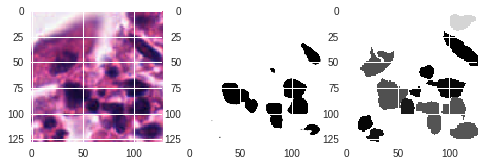

In [24]:
import torch as t
import sklearn.metrics
model = model.eval()
l = 100
i =1
g =1
l=1
val =0
count = 0
total_acc = 0

total_precision = 0
prec_number = 0
total_recall = 0
recall_number = 0
total_f_score = 0
f_score_number = 0
precision_number = 0
dice_val = 0



for data,mask in testdataloader:
    
      #print(data['name'])
      data = t.autograd.Variable(data, volatile=True).cuda()
      print(data.shape)
      o = model(data)
      #print(data['name'])
      tm=o[0][0].data.cpu().numpy()
      #q = l+21
      plt.subplot(131)
      plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
      #m = l+22
      plt.subplot(132)
      plt.imshow(tm)
      plt.subplot(133)
      plt.imshow(mask[0][0])
      print("output")
      print(tm.shape)
      print("mask")
      print(mask[0][0].shape)
      print("done")
      
      img1 = tm*255
      img2 = mask[0][0].numpy()*255
      print("Here img2")
      print(img2.max())
      print(img2)
      img2_resized = cv2.resize(img2, (128,128))
      [a,b] = img1.shape
      for i in range(a):
        for j in range(b):
          if (img1[i][j] > 125):
            img1[i][j] = 255
          else:
            img1[i][j] = 0


      for i in range(a):
        for j in range(b):
          if (img2_resized[i][j] > 125):
            img2_resized[i][j] = 255
          else:
            img2_resized[i][j] = 0 
            
      arr1 = img1.ravel(img1.shape)
      arr2 = img2_resized.ravel(img2.shape)
      arr2_reshaped = np.resize(arr2, arr1.shape[0])
      TP = 0
      for i in range(a):
        for j in range(b):
          if(img1[i][j] == 255) and (img2_resized[i][j] == 255):
            TP += 1
      TN = 0
      for i in range(a):
        for j in range(b):
          if(img1[i][j] == 0) and (img2_resized[i][j] == 0):
            TN += 1
      FP = 0
      for i in range(a):
        for j in range(b):
          if(img1[i][j] == 255) and (img2_resized[i][j] == 0):
            FP += 1
      FN = 0
      for i in range(a):
        for j in range(b):
          if(img1[i][j] == 0) and (img2_resized[i][j] == 255):
            FN += 1
      print (TP, TN, FP, FN, a*b)
      accuracy = float(TP + TN) / float(a * b)
      if(TP + FP != 0):
        precision = float(TP) / float(TP + FP)
        total_precision = total_precision + precision
        precision_number = precision_number+1
      if(TP+FN != 0):
        recall = float(TP) / float(TP + FN)
        total_recall = total_recall + recall
        recall_number = recall_number + 1
        if(recall != 0):
          f_score = float(precision) / float(recall)
          total_f_score = total_f_score + f_score
          f_score_number = f_score_number+1
      total_acc = total_acc + accuracy
      total_precision = total_precision + precision
      print("check #################################")
      print(accuracy)
      k = 255
      #dice = np.sum(img1[img2_resized==k])*2.0 / (np.sum(img1) + np.sum(img2_resized))
      print("DICE PROBLEM")
      print ('Dice similarity score is')
      dice = (dice_coeff(torch.from_numpy(tm), mask[0][0]/255)).item()
      print("check_dice")
      print(tm.shape)
      print((tm*255).max())
      print((tm*255).min())
      print(mask[0][0].shape)
      #print(dice_coeff(torch.from_numpy(tm*255), mask[0][0]*255))
      print("HERE")
      print(dice)
      print("max")
      print(img2_resized)
      print(img2_resized==k)
      dice_val = dice_val+dice
      
      
      
      
      
      
      #cv2.imwrite( "gdrive/My Drive/CV_semantic/OUTPUT/"+"org_mask_"+str(g)+".png", mask[0][0].numpy()*255);
      #cv2.imwrite( "gdrive/My Drive/CV_semantic/OUTPUT/"+"generated_mask_"+str(g)+".png", tm*255);
      jaccard_index_value = sklearn.metrics.jaccard_similarity_score(arr2_reshaped, arr1, normalize = True)
      print(jaccard_index_value)
      val = val +jaccard_index_value
      l = l+100
      i= i+1
      count = count +1
      
      
print("final Jaccard ")
print(val/count) 
print("acc")
print(total_acc/count)
print("precision")
print(total_precision/precision_number)
print("recall")
print(total_recall/recall_number)
print("f-score")
print(total_f_score/f_score_number)
print("dice")
print(dice_val/count)
    

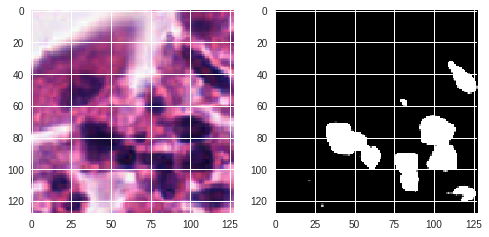

In [25]:
tm=o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm*(-255))


In [0]:

cv2.imwrite( "Gray_Image2.jpg", tm*255 );

In [0]:
import cv2
retval, threshold = cv2.threshold(tm, 10, 255, cv2.THRESH_BINARY)

In [0]:
cv2.imshow('threshold',threshold)

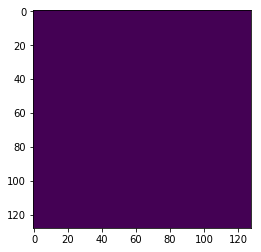

In [0]:
plt.imshow(threshold)

In [0]:
t = (tm>1)

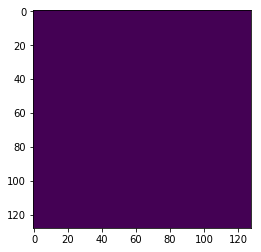

In [0]:
plt.imshow(t)

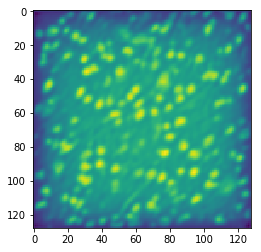

In [0]:
plt.imshow(tm)

In [0]:
Image.fromarray(final_segmentation).resize(original_size, resample=Image.NEAREST).save('{}_finalseg.png'.format(file_id))